# Method:
1. Iterate over the entire dataset of images (MS COCO Training 2017).
2. Separate foregrounds and backgrounds of these images.
3. Store the separate parts in folders named as such: train foreground and train backgrounds.
4. Iterate over foreground folder.
5. Induce random motion blur (obtained from the MTech thesis) into all the foreground images. Store into a directory named 'train random blur'.
6. Match images from 'train random blur' to corresponding backgrounds.
7. Superimpose blurred foregrounds on the backgrounds.
8. Save separately as 'train new blurred dataset using random blur'.
9. Repeat for test and validation sets.

# Training Data

Separating foreground and background from the input images.

In [2]:
import cv2
import os

input_dir = "/home/hrishikesh/Downloads/cocodataset/train2017"

for filename in os.listdir(input_dir):
    # Reading the image
    image = cv2.imread(os.path.join(input_dir, filename))
    
    # Processing the image - separating foreground and background using cv2.threshold() function
    # cv2.threshold() can be replaced with any other algorithm if it provides better results
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Create a binary mask using thresholding
    ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    
    # Extract the foreground of the image
    foreground = cv2.bitwise_and(image, image, mask=thresh)
    
    # Invert the binary mask
    mask = cv2.bitwise_not(thresh)
    
    # Extract the background of the image
    background = cv2.bitwise_and(image, image, mask = mask)
    
    # Save the resulting images
    cv2.imwrite(os.path.join("/home/hrishikesh/Downloads/cocodataset/foreground", filename), foreground)
    cv2.imwrite(os.path.join("/home/hrishikesh/Downloads/cocodataset/background", filename), background)

Creating motion blur function using averaging kernel.

In [1]:
# Using the motion blur kernel from the MTech Thesis

import numpy as np
import cv2
# from google.colab.patches import cv2_imshow
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
# import random
from random import randrange,random,choice
import time

def blurkernel(i): # takes parameters for blurring as input as an array 'i'.
  ker_size=2*i[0]+1;  # The first parameter is (kernel_size-1)/2.
  blur=np.zeros((ker_size,ker_size))
  # blur[i[0],i[0]:ker_size] = (1/(i[0]+1))*np.ones(i[0]+1)

  #implementing non-symmetric blurring for realistic blurring.
  blur[i[0],:]= (1/(ker_size))*np.ones(ker_size)

  # blur[i[0],0:ker_size+1]=(1/ker_size)*np.ones(ker_size) #symmetric blurring
  
  if i[1]!=0:     # the second parameter is blur angle.
    (h, w) = blur.shape
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), i[1], 1.0)
    rotated = cv2.warpAffine(blur, M, (w, h))
  else:
    rotated=blur
  rotated=rotated/rotated.sum()
  return rotated

def motionblur(image,i):
  ker_size=2*i[0]+1;
  blur=np.zeros((ker_size,ker_size))
  # blur[i[0],i[0]:ker_size] = (1/(i[0]+1))*np.ones(i[0]+1)
  blur[i[0],:]= (1/(ker_size))*np.ones(ker_size)
  # blur[i[0],0:ker_size+1]=(1/ker_size)*np.ones(ker_size) #symmetric blurring
  if i[1]!=0:
    (h, w) = blur.shape
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), i[1], 1.0)
    rotated = cv2.warpAffine(blur, M, (w, h))
  else:
    rotated=blur
  rotated=rotated/rotated.sum()
  # plt.figure()
  # plt.imshow(rotated,cmap='gray')
  # plt.title("blur applied")
  output = cv2.filter2D(image,-1,rotated,borderType=cv2.BORDER_CONSTANT  )
  return output

Inducing random motion blur into the foregrounds of the entire training dataset.

In [2]:
# Iterating through the entire training dataset foreground images to induce random motion blur

img_dir = "/home/hrishikesh/Downloads/cocodataset/foreground"
blurred_img_dir = "/home/hrishikesh/Downloads/cocodataset/random blur"
for filename in os.listdir(img_dir):
    img = cv2.imread(os.path.join(img_dir, filename))
    ker_size = randrange(2,11)*2+1
    angle = choice([0,randrange(1,360)])
    output_img = motionblur(img,[ker_size,angle])
    cv2.imwrite(os.path.join(blurred_img_dir, filename), output_img)

**Some examples of the random blurred images (only foregrounds)**

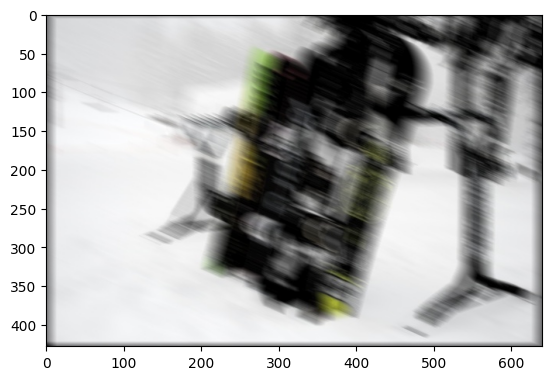

In [5]:
import matplotlib.pyplot as plt

image_show_1 = plt.imread("/home/hrishikesh/Downloads/cocodataset/random blur/000000000201.jpg")
plt.imshow(image_show_1)

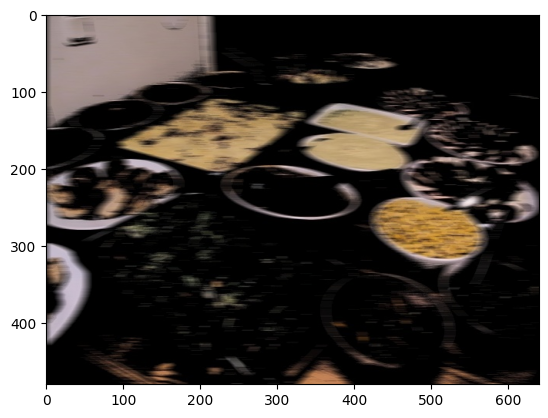

In [6]:
image_show_2 = plt.imread("/home/hrishikesh/Downloads/cocodataset/random blur/000000000196.jpg")
plt.imshow(image_show_2)

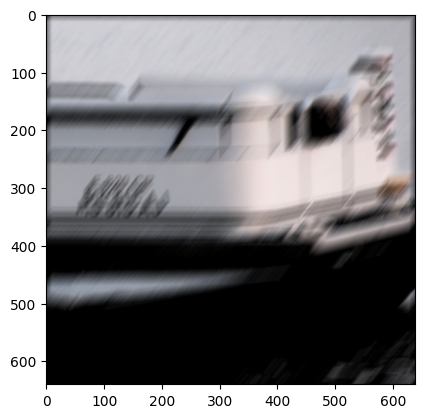

In [7]:
image_show_3 = plt.imread("/home/hrishikesh/Downloads/cocodataset/random blur/000000000400.jpg")
plt.imshow(image_show_3)

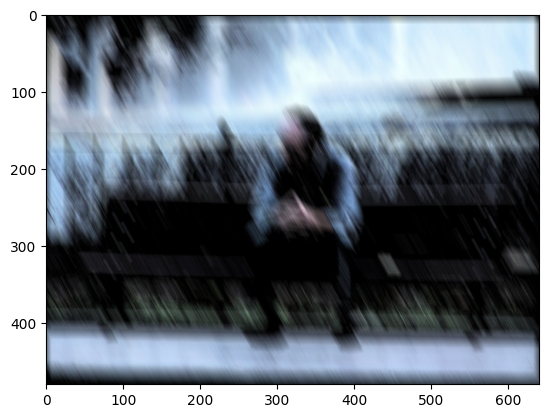

In [8]:
image_show_4 = plt.imread("/home/hrishikesh/Downloads/cocodataset/random blur/000000000510.jpg")
plt.imshow(image_show_4)

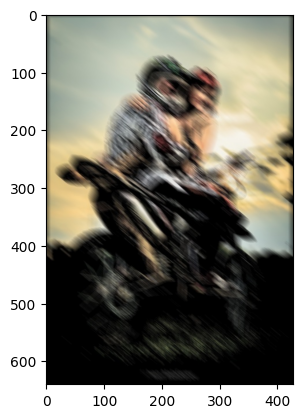

In [9]:
image_show_5 = plt.imread("/home/hrishikesh/Downloads/cocodataset/random blur/000000000529.jpg")
plt.imshow(image_show_5)

**This script should ideally match the foreground to its corresponding background.**

In [12]:
import cv2
import os

# Set the input and output directories
bg_dir = "/home/hrishikesh/Downloads/cocodataset/background"
fg_dir = "/home/hrishikesh/Downloads/cocodataset/random blur"
output_dir = "/home/hrishikesh/Downloads/cocodataset/new blurred dataset using random blur"

# Loop through all the foreground images
for fg_filename in os.listdir(fg_dir):
    # Read the foreground image
    fg_image = cv2.imread(os.path.join(fg_dir, fg_filename))

    # Extract the base name of the foreground image
    fg_basename = os.path.splitext(fg_filename)[0]

    # Find the corresponding background image
    bg_filename = fg_basename + ".jpg"
    bg_image = cv2.imread(os.path.join(bg_dir, bg_filename))

    # Resize the foreground image to the same size as the background image
    fg_image = cv2.resize(fg_image, (bg_image.shape[1], bg_image.shape[0]))

    # Blend the images together using the cv2.addWeighted() function
    result = cv2.addWeighted(bg_image, 0.3, fg_image, 0.7, 0)

    # Save the resulting image
    cv2.imwrite(os.path.join(output_dir,fg_basename + '_' + fg_basename + '.jpg'), result)

The weight of the foreground and background can be adjusted to better suit our requirement, which is foreground-heavy. This works as a general program which converts the sharp MS COCO image to a blurred image. I will now change the weights to reflect the following:
1. Weight for foreground = 70% (0.7)
2. Weight for background = 30% (0.3)

**Some examples of random blurred images (after matching the blurred foregrounds to their corresponding backgrounds)**

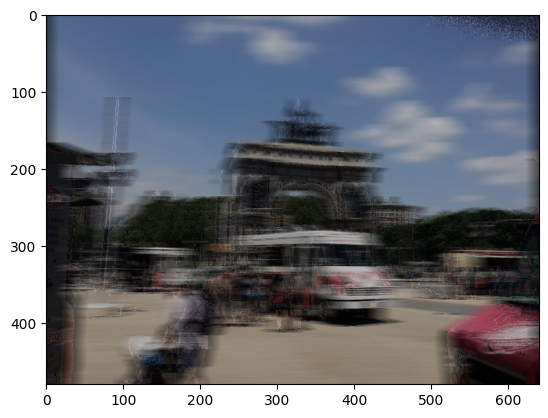

In [13]:
import matplotlib.pyplot as plt

new_image_show_1 = plt.imread("/home/hrishikesh/Downloads/cocodataset/new blurred dataset using random blur/000000000257_000000000257.jpg")
plt.imshow(new_image_show_1)

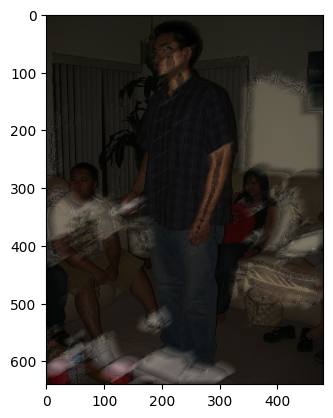

In [14]:
new_image_show_2 = plt.imread("/home/hrishikesh/Downloads/cocodataset/new blurred dataset using random blur/000000000241_000000000241.jpg")
plt.imshow(new_image_show_2)

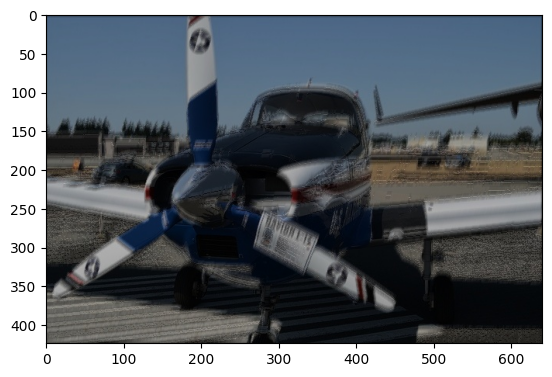

In [15]:
new_image_show_3 = plt.imread("/home/hrishikesh/Downloads/cocodataset/new blurred dataset using random blur/000000000247_000000000247.jpg")
plt.imshow(new_image_show_3)

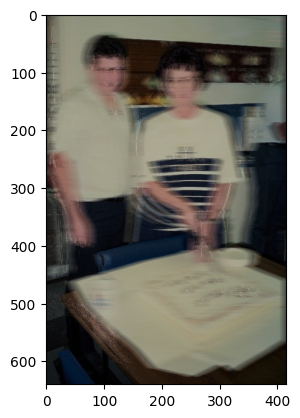

In [16]:
new_image_show_4 = plt.imread("/home/hrishikesh/Downloads/cocodataset/new blurred dataset using random blur/000000000113_000000000113.jpg")
plt.imshow(new_image_show_4)

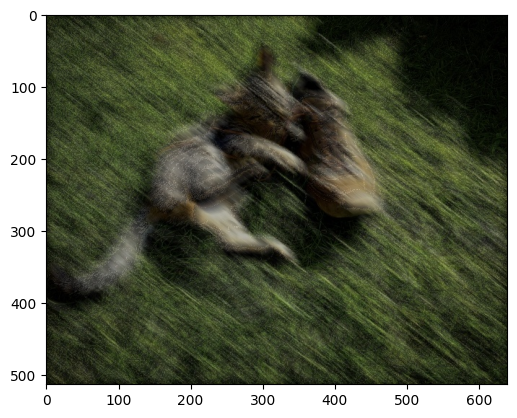

In [17]:
new_image_show_5 = plt.imread("/home/hrishikesh/Downloads/cocodataset/new blurred dataset using random blur/000000000575_000000000575.jpg")
plt.imshow(new_image_show_5)

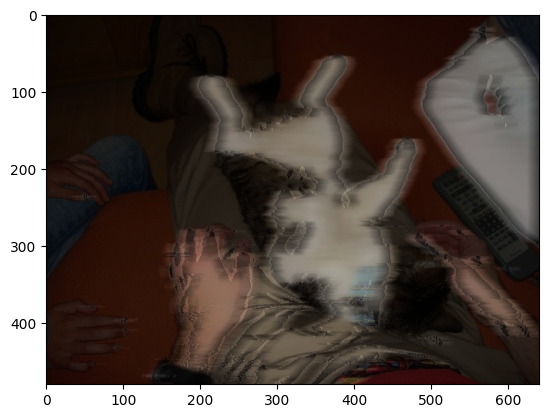

In [18]:
new_image_show_6 = plt.imread("/home/hrishikesh/Downloads/cocodataset/new blurred dataset using random blur/000000000443_000000000443.jpg")
plt.imshow(new_image_show_6)

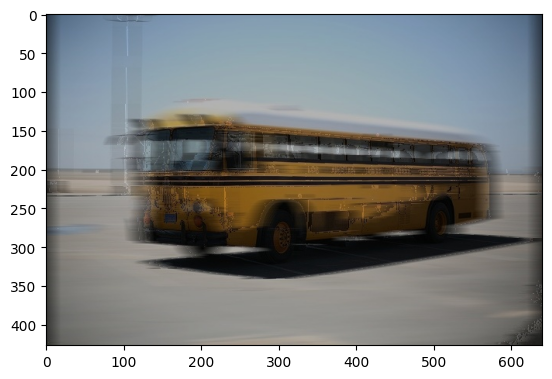

In [19]:
new_image_show_7 = plt.imread("/home/hrishikesh/Downloads/cocodataset/new blurred dataset using random blur/000000000471_000000000471.jpg")
plt.imshow(new_image_show_7)

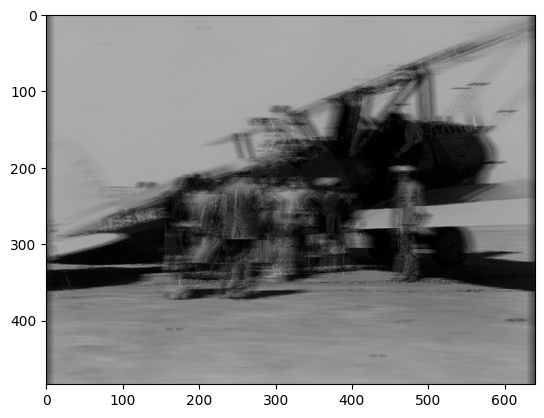

In [20]:
new_image_show_8 = plt.imread("/home/hrishikesh/Downloads/cocodataset/new blurred dataset using random blur/000000000542_000000000542.jpg")
plt.imshow(new_image_show_8)

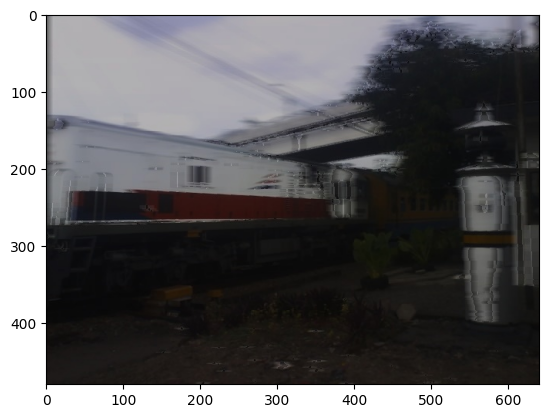

In [21]:
new_image_show_9 = plt.imread("/home/hrishikesh/Downloads/cocodataset/new blurred dataset using random blur/000000000349_000000000349.jpg")
plt.imshow(new_image_show_9)

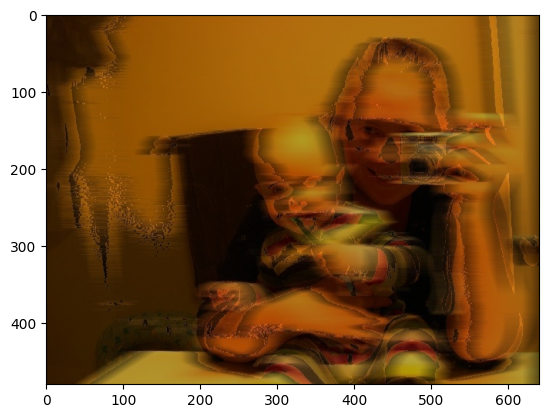

In [22]:
new_image_show_10 = plt.imread("/home/hrishikesh/Downloads/cocodataset/new blurred dataset using random blur/000000000692_000000000692.jpg")
plt.imshow(new_image_show_10)

# Validation Set

Separating foreground and background from the input images.

In [23]:
# Separating foreground and background of validation set

import cv2
import os

input_dir = "/home/hrishikesh/Downloads/cocodataset/val2017"

for filename in os.listdir(input_dir):
    # Reading the image
    image = cv2.imread(os.path.join(input_dir, filename))
    
    # Processing the image - separating foreground and background using cv2.threshold() function
    # cv2.threshold() can be replaced with any other algorithm if it provides better results
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Create a binary mask using thresholding
    ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    
    # Extract the foreground of the image
    foreground = cv2.bitwise_and(image, image, mask=thresh)
    
    # Invert the binary mask
    mask = cv2.bitwise_not(thresh)
    
    # Extract the background of the image
    background = cv2.bitwise_and(image, image, mask = mask)
    
    # Save the resulting images
    cv2.imwrite(os.path.join("/home/hrishikesh/Downloads/cocodataset/validation foreground", filename), foreground)
    cv2.imwrite(os.path.join("/home/hrishikesh/Downloads/cocodataset/validation background", filename), background)

Using the same random motion blur kernel defined above to induce blur into all the validation images.

In [24]:
# Iterating through the entire training dataset foreground images to induce random motion blur

img_dir = "/home/hrishikesh/Downloads/cocodataset/validation foreground"
blurred_img_dir = "/home/hrishikesh/Downloads/cocodataset/validation random blur"
for filename in os.listdir(img_dir):
    img = cv2.imread(os.path.join(img_dir, filename))
    ker_size = randrange(2,11)*2+1
    angle = choice([0,randrange(1,360)])
    output_img = motionblur(img,[ker_size,angle])
    cv2.imwrite(os.path.join(blurred_img_dir, filename), output_img)

**Some examples of blurred validation set images**

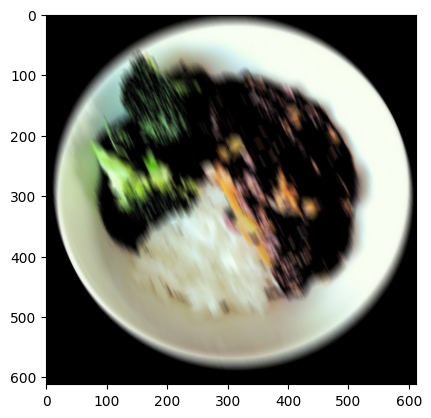

In [25]:
val_show_1 = plt.imread("/home/hrishikesh/Downloads/cocodataset/validation random blur/000000003501.jpg")
plt.imshow(val_show_1)

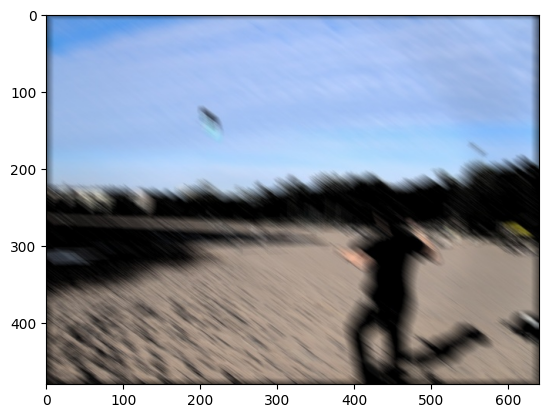

In [26]:
val_show_2 = plt.imread("/home/hrishikesh/Downloads/cocodataset/validation random blur/000000007511.jpg")
plt.imshow(val_show_2)

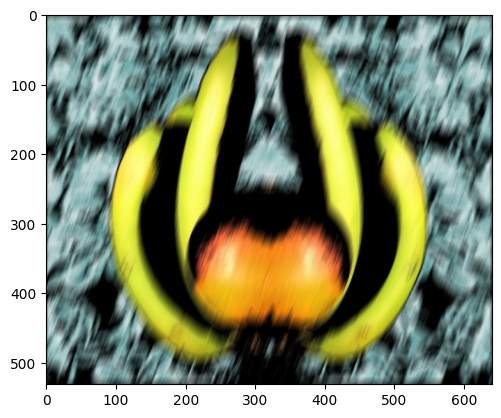

In [27]:
val_show_3 = plt.imread("/home/hrishikesh/Downloads/cocodataset/validation random blur/000000006012.jpg")
plt.imshow(val_show_3)

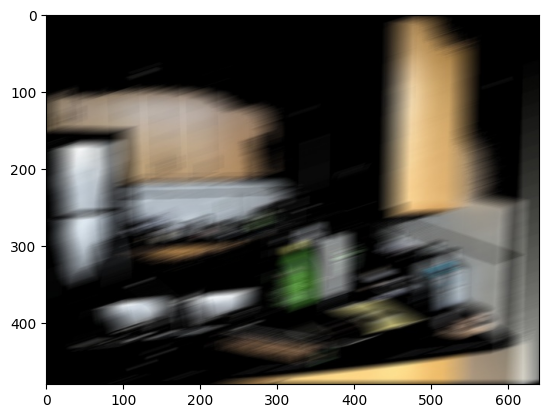

In [28]:
val_show_4 = plt.imread("/home/hrishikesh/Downloads/cocodataset/validation random blur/000000007574.jpg")
plt.imshow(val_show_4)

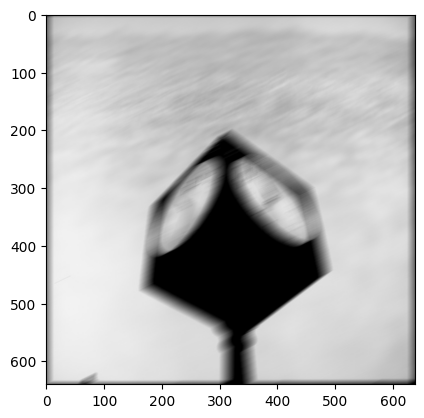

In [29]:
val_show_5 = plt.imread("/home/hrishikesh/Downloads/cocodataset/validation random blur/000000007888.jpg")
plt.imshow(val_show_5)

**This script should ideally match the foreground to its corresponding background.**

In [30]:
import cv2
import os

# Set the input and output directories
bg_dir = "/home/hrishikesh/Downloads/cocodataset/validation background"
fg_dir = "/home/hrishikesh/Downloads/cocodataset/validation random blur"
output_dir = "/home/hrishikesh/Downloads/cocodataset/validation new blurred dataset using random blur"

# Loop through all the foreground images
for fg_filename in os.listdir(fg_dir):
    # Read the foreground image
    fg_image = cv2.imread(os.path.join(fg_dir, fg_filename))

    # Extract the base name of the foreground image
    fg_basename = os.path.splitext(fg_filename)[0]

    # Find the corresponding background image
    bg_filename = fg_basename + ".jpg"
    bg_image = cv2.imread(os.path.join(bg_dir, bg_filename))

    # Resize the foreground image to the same size as the background image
    fg_image = cv2.resize(fg_image, (bg_image.shape[1], bg_image.shape[0]))

    # Blend the images together using the cv2.addWeighted() function
    result = cv2.addWeighted(bg_image, 0.3, fg_image, 0.7, 0)

    # Save the resulting image
    cv2.imwrite(os.path.join(output_dir,fg_basename + '_' + fg_basename + '.jpg'), result)

**Some examples of blurred validation set images (after matching)**

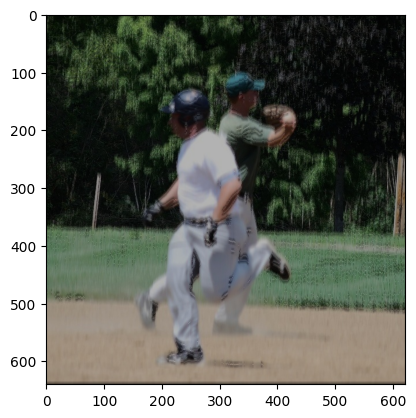

In [33]:
new_val_show_1 = plt.imread("/home/hrishikesh/Downloads/cocodataset/validation new blurred dataset using random blur/000000000872_000000000872.jpg")
plt.imshow(new_val_show_1)

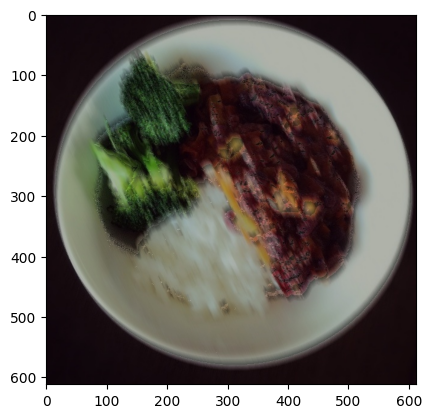

In [34]:
new_val_show_2 = plt.imread("/home/hrishikesh/Downloads/cocodataset/validation new blurred dataset using random blur/000000003501_000000003501.jpg")
plt.imshow(new_val_show_2)

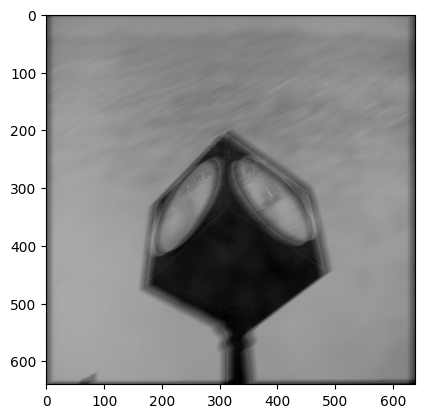

In [35]:
new_val_show_3 = plt.imread("/home/hrishikesh/Downloads/cocodataset/validation new blurred dataset using random blur/000000007888_000000007888.jpg")
plt.imshow(new_val_show_3)

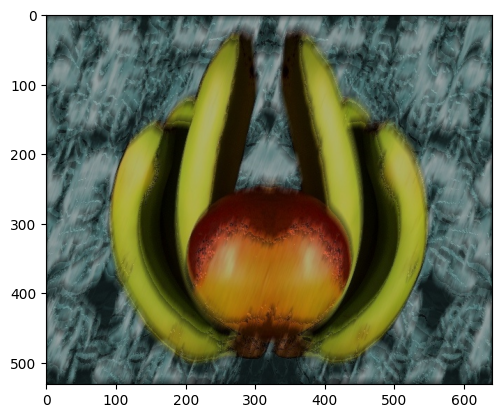

In [36]:
new_val_show_4 = plt.imread("/home/hrishikesh/Downloads/cocodataset/validation new blurred dataset using random blur/000000006012_000000006012.jpg")
plt.imshow(new_val_show_4)

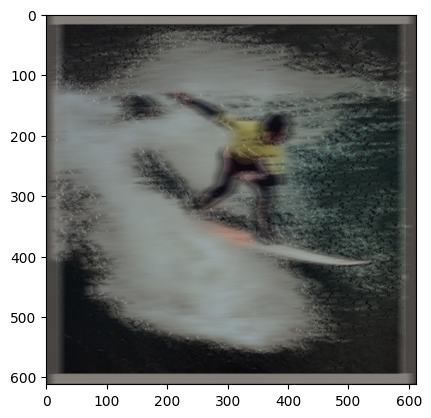

In [37]:
new_val_show_5 = plt.imread("/home/hrishikesh/Downloads/cocodataset/validation new blurred dataset using random blur/000000004765_000000004765.jpg")
plt.imshow(new_val_show_5)